In [1]:
# Data management
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Graphics
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Preprocessing and modelling
# ------------------------------------------------------------------------------
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

from sklearn.metrics import accuracy_score
from sklearn import metrics 


# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
#warnings.filterwarnings('once')
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import csv

# Ruta del CSV generado
archivo_csv = "dataset_con_texto.csv"

# Leer el CSV cuidadosamente
df = pd.read_csv(
    archivo_csv,
    encoding="utf-8",
    quotechar='"',         # Asegura que las comillas dobles delimitan campos
    escapechar='\\',       # En caso de que haya caracteres escapados
    quoting=csv.QUOTE_ALL, # Coincide con la escritura del CSV
    low_memory=False       # Evita fragmentación de tipos si hay mezcla de datos
)

# Mostrar las dimensiones y las primeras filas
print("✅ CSV cargado correctamente.")
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
display(df.head(3))  # Si estás en Jupyter, esto mostrará una tabla bonita

# Verifica que no haya columnas enteras con NaN
print("\nColumnas con demasiados NaN (más del 90% de los valores faltantes):")
missing = df.isna().mean()
print(missing[missing > 0.9])

# Verifica que las columnas `text` y `translation` estén bien formadas
print("\nEjemplo de texto y traducción:")
print("→ text:", df["text"].iloc[0][:200], "...")
print("→ translation:", df["translation"].iloc[0][:200], "...")


✅ CSV cargado correctamente.
Filas: 6926, Columnas: 84


,created_at,aid,extension,format,duration,FILE_STORED,FACIAL_ANALYSED,VOICE_ANALYSED,VOICE_TRANSCRIBED,BIOMETRICS_EXTRACTED,...,no_speech_prob,entropy,tense_past,tense_present,tense_future,sentiment_polarity,sentiment_subjectivity,variable,text,translation
0,1745237541,3f241254-97fe-4886-8297-3838d272ea84,.mp4,video,52,True,True,True,True,True,...,0.031288,4.1018,0.0,1.0,0.0,-0.0617,0.7107,Ansiedad,Cuando estÃ¡s en medio de un ataque de pÃ¡nico...,When you are in the middle of a panic attack ...
1,1745237542,9e19679c-a1cb-4754-85ac-da0219e1398f,.mp4,video,60,True,True,True,True,True,...,0.170642,4.4279,0.8,0.2,0.0,0.0830,0.4569,Ansiedad,Eso se llama ansiedad. Â¿Y yo quÃ© es eso? Â¿Q...,That's called anxiety. What is anxiety? I've ...
2,1745237543,576c3f41-8d6a-402b-858a-54770ad42345,.mp4,video,51,True,True,True,True,True,...,0.120449,4.0927,0.0,1.0,0.0,0.1143,0.6179,Ansiedad,"1. Por mÃ¡s denza que sea la oscuridad, siempr...","Number one, for more dense than the darkness,..."



Columnas con demasiados NaN (más del 90% de los valores faltantes):
dominant_emotion_counts_surprise    0.901242
dtype: float64

Ejemplo de texto y traducción:
→ text: Cuando estÃ¡s en medio de un ataque de pÃ¡nico o una ataque de ansiedad, no busques la calma. Porque buscar la calma es un tipo de resistencia, es como decirle a tu cuerpo. Oye, no quiero estas sensac ...
→ translation:  When you are in the middle of a panic attack or an anxiety attack, do not look for the calm. Because looking for calm is a type of resistance, it is like telling your body, or I do not want these sen ...


In [2]:
# Binarizamos la variable objetivo: 1 para Ansiedad o Depresión, 0 para Control
df["target"] = df["variable"].apply(lambda x: 1 if x in ["Ansiedad", "Depresion"] else 0)

# Mostramos la distribución original de clases
print("Distribución de clases en 'variable':")
print(df["variable"].value_counts())

# Comprobamos cómo queda la variable binaria
print("\nDistribución en 'target' (1 = Ansiedad o Depresión, 0 = Control):")
print(df["target"].value_counts())

# Vemos algunas filas como ejemplo
df[["variable", "target"]].head()


Distribución de clases en 'variable':
variable
Control      2433
Depresion    2260
Ansiedad     2233
Name: count, dtype: int64

Distribución en 'target' (1 = Ansiedad o Depresión, 0 = Control):
target
1    4493
0    2433
Name: count, dtype: int64


,variable,target
0,Ansiedad,1
1,Ansiedad,1
2,Ansiedad,1
3,Ansiedad,1
4,Ansiedad,1


In [3]:
# Guardamos aparte las columnas de texto antes de limpiar el dataframe
text_cols = df[["text", "translation"]].copy()

# Paso 1: Eliminamos columnas no numéricas o que no aportan información predictiva
cols_to_drop = [
    'created_at', 'aid', 'extension', 'format', 'duration',
    'FILE_STORED', 'FACIAL_ANALYSED', 'VOICE_ANALYSED', 'VOICE_TRANSCRIBED',
    'BIOMETRICS_EXTRACTED', 'SPEECH_ANALYSED', 'PERSONALITY_ANALYSED',
    'FACES_EXTRACTED', 'id', 'variable'  # 'variable' ya fue convertida en 'target'
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Paso 2: Eliminamos la columna que está mayoritariamente vacía
df.drop(columns=['dominant_emotion_counts_surprise'], inplace=True, errors='ignore')

# Paso 3: Rellenamos los valores nulos según el tipo de dato
columnas_con_nulos = df.columns[df.isnull().any()].tolist()

for col in columnas_con_nulos:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].median())  # usamos la mediana para valores numéricos
    else:
        df[col] = df[col].fillna(df[col].mode()[0])  # para categorías, rellenamos con la moda
        print(f"🟦 Columna categórica '{col}' rellenada con su moda")

# Paso 4: Verificamos que no quedan valores nulos
print("✅ Nulos restantes tras limpieza:", df.isnull().sum().sum())

# Paso 5: Separamos las variables predictoras (X) y la variable objetivo (y)
X = df.drop(columns='target')
y = df['target']

# Paso 6: Volvemos a añadir las columnas de texto por si se quieren usar más adelante
X["text"] = text_cols["text"]
X["translation"] = text_cols["translation"]

# Mostramos dimensiones finales tras la limpieza
print(f"✅ Dimensiones finales: X = {X.shape}, y = {y.shape}")


🟦 Columna categórica 'most_frequent_dominant_emotion' rellenada con su moda
🟦 Columna categórica 'language' rellenada con su moda
🟦 Columna categórica 'text' rellenada con su moda
🟦 Columna categórica 'translation' rellenada con su moda
✅ Nulos restantes tras limpieza: 0
✅ Dimensiones finales: X = (6926, 68), y = (6926,)


In [4]:
# Identificamos columnas categóricas que contienen texto o símbolos musicales no procesables directamente
columnas_categoricas = [
    'most_frequent_dominant_emotion',
    'voice_mean_note',
    'voice_median_note',
    'voice_mode_note',
    'voice_Q25_note',
    'voice_Q75_note',
    'language'
]

# Eliminamos estas columnas del conjunto de entrada para evitar errores en el entrenamiento
X = X.drop(columns=columnas_categoricas, errors='ignore')

# Mostramos las nuevas dimensiones del conjunto de entrada
print(f"✅ Nuevas dimensiones de X tras eliminar texto: {X.shape}")


✅ Nuevas dimensiones de X tras eliminar texto: (6926, 61)


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Guardamos las columnas de texto por separado, por si se quieren usar más adelante
X_text = X[["text", "translation"]].copy()

# Eliminamos esas columnas del conjunto X, dejando solo variables numéricas
X = X.drop(columns=["text", "translation"])

# Paso 1: Escalamos los datos para que todas las variables numéricas estén en la misma escala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 2: Dividimos los datos en conjunto de entrenamiento y de prueba (75%/25%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)


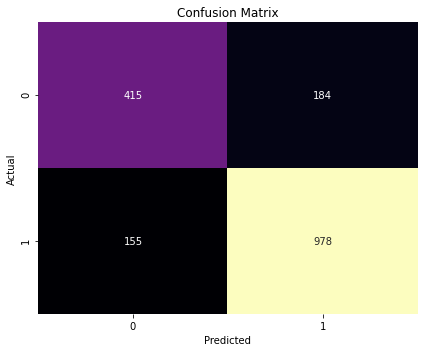

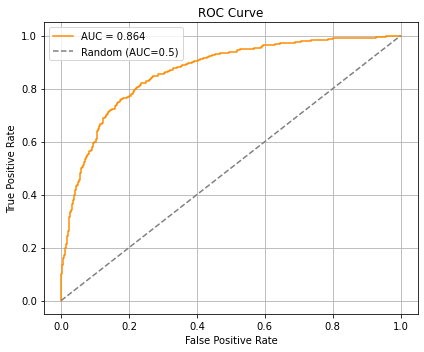

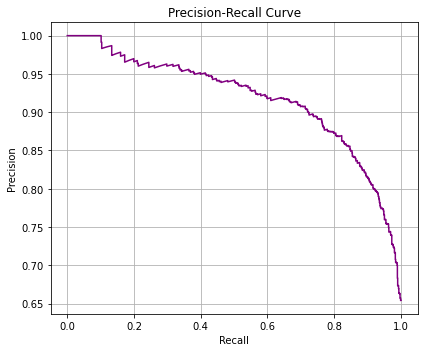

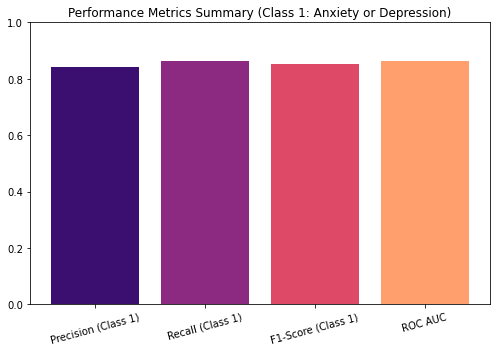

📊 Full classification report:

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       599
           1       0.84      0.86      0.85      1133

    accuracy                           0.80      1732
   macro avg       0.78      0.78      0.78      1732
weighted avg       0.80      0.80      0.80      1732



In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a consistent and visually distinct color palette
sns.set_palette("magma")

# Reconstruct the cleaned dataframe from scratch (if not already)
df = pd.read_csv("dataset_con_texto.csv", encoding="utf-8", quotechar='"')

# Binarize the target variable: 1 if anxiety or depression, 0 if control
df["target"] = df["variable"].apply(lambda x: 1 if x in ["Ansiedad", "Depresion"] else 0)

# Drop irrelevant or categorical columns (already analyzed or non-numeric)
cols_to_drop = [
    'created_at', 'aid', 'extension', 'format', 'duration',
    'FILE_STORED', 'FACIAL_ANALYSED', 'VOICE_ANALYSED', 'VOICE_TRANSCRIBED',
    'BIOMETRICS_EXTRACTED', 'SPEECH_ANALYSED', 'PERSONALITY_ANALYSED',
    'FACES_EXTRACTED', 'id', 'variable',
    'dominant_emotion_counts_surprise',
    'most_frequent_dominant_emotion', 'voice_mean_note', 'voice_median_note',
    'voice_mode_note', 'voice_Q25_note', 'voice_Q75_note', 'language',
    'text', 'translation'
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Fill missing values appropriately based on data type
for col in df.columns:
    if df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

# Separate features and target
X = df.drop(columns='target')
y = df['target']

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Generate predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Compute evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
prec, rec, _ = precision_recall_curve(y_test, y_prob)

# --- Plot 1: Confusion matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- Plot 2: ROC curve ---
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 3: Precision-Recall curve ---
plt.figure(figsize=(6, 5))
plt.plot(rec, prec, color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 4: Bar chart with key performance metrics ---
metrics = {
    "Precision (Class 1)": report["1"]["precision"],
    "Recall (Class 1)": report["1"]["recall"],
    "F1-Score (Class 1)": report["1"]["f1-score"],
    "ROC AUC": roc_auc
}

plt.figure(figsize=(7, 5))
plt.bar(metrics.keys(), metrics.values(), color=sns.color_palette("magma", n_colors=4))
plt.ylim(0, 1)
plt.title("Performance Metrics Summary (Class 1: Anxiety or Depression)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# --- Print full classification report ---
print("📊 Full classification report:\n")
print(classification_report(y_test, y_pred))


In [9]:
import statsmodels.api as sm
import pandas as pd

# Rebuild X_train as a DataFrame with proper column names and index matching y_train
X_train_df = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)

# Add an intercept term to the model (constant column)
X_train_df = sm.add_constant(X_train_df)

# Fit a logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_df).fit()

# Display a detailed summary of the model, including coefficients and significance
print(logit_model.summary())


         Current function value: 0.404411
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 5194
Model:                          Logit   Df Residuals:                     5134
Method:                           MLE   Df Model:                           59
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                  0.3772
Time:                        10:21:54   Log-Likelihood:                -2100.5
converged:                      False   LL-Null:                       -3372.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       1.5872      0.067     23.844      0.000       1.457       1.718
angry_facial              

C:\Users\cscpd\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


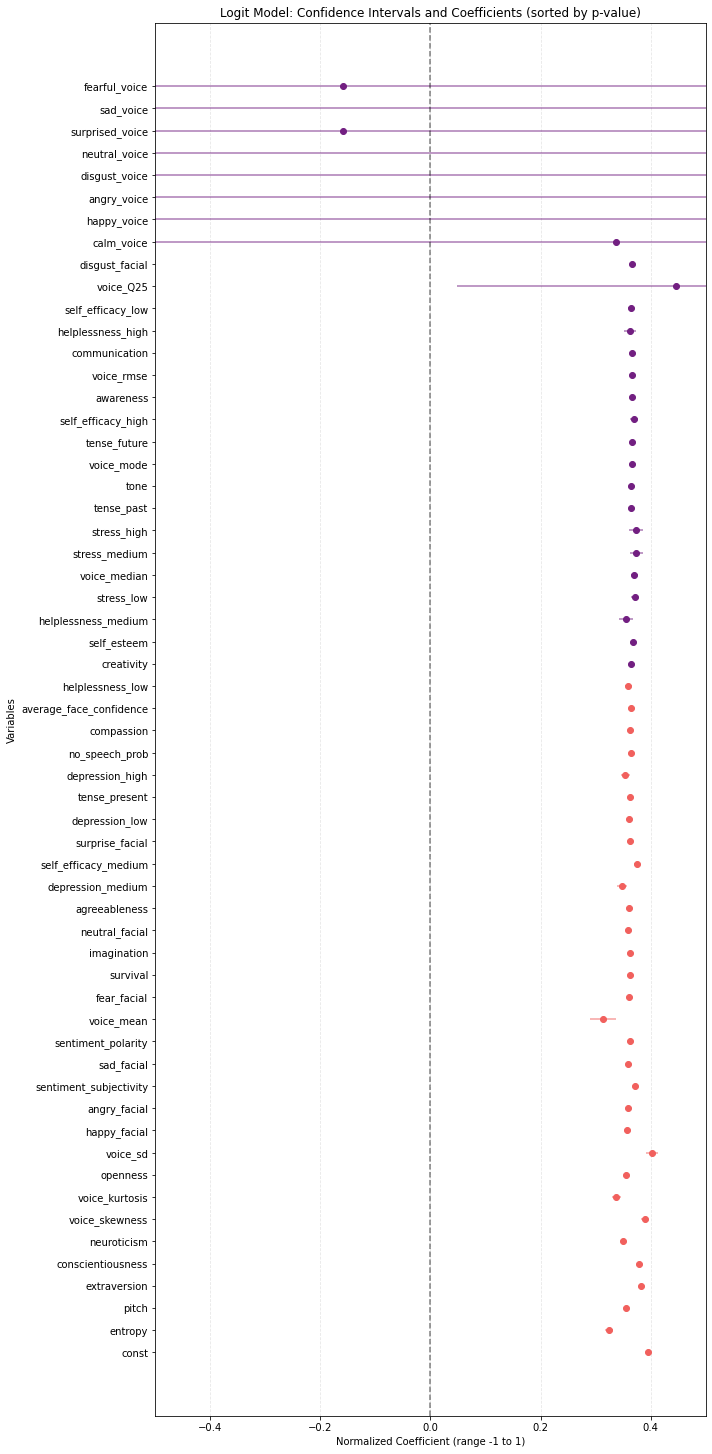

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent color palette
sns.set_palette("magma")

# Extract coefficients, confidence intervals, and p-values from the logit model
coefs = logit_model.params
conf = logit_model.conf_int()
conf.columns = ["lower", "upper"]
pvals = logit_model.pvalues

# Clip extreme coefficient values to avoid visual distortion
mean_val = coefs.mean()
std_val = coefs.std()
clip_min = mean_val - 3 * std_val
clip_max = mean_val + 3 * std_val
coefs_capped = coefs.clip(lower=clip_min, upper=clip_max)
conf_capped = conf.clip(lower=clip_min, upper=clip_max)

# Normalize all values to range [-1, 1] for better comparison
min_val = coefs_capped.min()
max_val = coefs_capped.max()
coefs_norm = 2 * (coefs_capped - min_val) / (max_val - min_val) - 1
conf_norm = 2 * (conf_capped - min_val) / (max_val - min_val) - 1

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    "coef": coefs_norm,
    "lower": conf_norm["lower"],
    "upper": conf_norm["upper"],
    "var": coefs.index,
    "pval": pvals
})

# Optionally exclude outlier variables from the plot
variables_to_exclude = ["voice_Q75", "voice_IQR"]
df_plot = df_plot[~df_plot["var"].isin(variables_to_exclude)]

# Assign color based on statistical significance
df_plot["color"] = df_plot["pval"].apply(lambda p: sns.color_palette("magma", 2)[1] if p < 0.05 else sns.color_palette("magma", 2)[0])

# Sort variables by p-value (most significant on top)
df_plot = df_plot.sort_values("pval")

# Plot confidence intervals and normalized coefficients
plt.figure(figsize=(10, len(df_plot) * 0.35))
for _, row in df_plot.iterrows():
    plt.hlines(y=row["var"], xmin=row["lower"], xmax=row["upper"], color=row["color"], alpha=0.6)
    plt.plot(row["coef"], row["var"], "o", color=row["color"])

# Add reference line at 0
plt.axvline(x=0, linestyle="--", color="black", alpha=0.5)

# Configure axis limits and labels
plt.xlim(-0.5, 0.5)
plt.xlabel("Normalized Coefficient (range -1 to 1)")
plt.ylabel("Variables")
plt.title("Logit Model: Confidence Intervals and Coefficients (sorted by p-value)")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


📊 Confusion matrix:
 [[ 484  115]
 [  78 1055]]

📋 Classification report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83       599
           1       0.90      0.93      0.92      1133

    accuracy                           0.89      1732
   macro avg       0.88      0.87      0.87      1732
weighted avg       0.89      0.89      0.89      1732

🧠 ROC AUC score: 0.9458799381729184


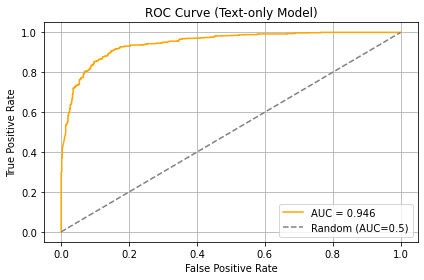

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent color palette
sns.set_palette("magma")

# Step 1: Convert the 'translation' text into TF-IDF vectors (max 300 features)
tfidf = TfidfVectorizer(max_features=300)
X_text_tfidf = tfidf.fit_transform(X_text["translation"].fillna("")).toarray()

# Step 2: Split the text data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_text_tfidf, y, test_size=0.25, random_state=42
)

# Step 3: Train a logistic regression model on the text data
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 4: Make predictions and calculate evaluation metrics
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Print evaluation results
print("📊 Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification report:\n", classification_report(y_test, y_pred))
print("🧠 ROC AUC score:", roc_auc_score(y_test, y_prob))

# Step 5: Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Text-only Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 432x360 with 0 Axes>

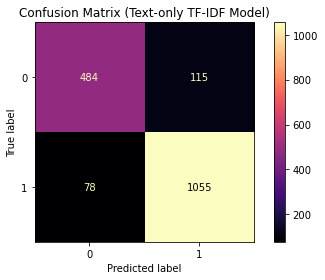

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("magma")

# Plot confusion matrix
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma')
plt.title("Confusion Matrix (Text-only TF-IDF Model)")
plt.grid(False)
plt.tight_layout()
plt.show()


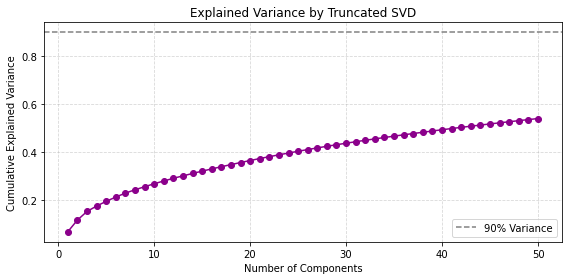

In [14]:
from sklearn.decomposition import TruncatedSVD

# Compute SVD to explore dimensionality
svd = TruncatedSVD(n_components=50, random_state=42)
svd.fit(X_text_tfidf)
explained_variance = svd.explained_variance_ratio_

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(range(1, 51), explained_variance.cumsum(), marker='o', color='darkmagenta')
plt.axhline(0.9, color='gray', linestyle='--', label='90% Variance')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by Truncated SVD")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\cscpd\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\cscpd\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


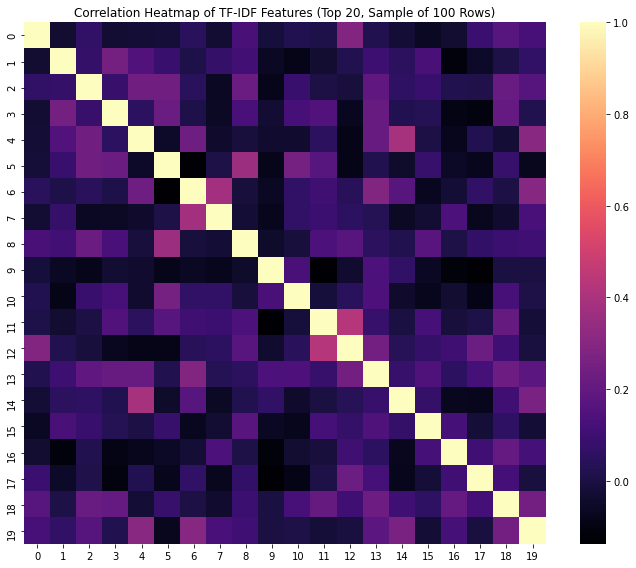

In [15]:
import numpy as np

# Compute correlation matrix on a subset for readability
correlated_matrix = np.corrcoef(X_text_tfidf[:100].T)

# Plot heatmap of top 20 features
plt.figure(figsize=(10, 8))
sns.heatmap(correlated_matrix[:20, :20], cmap='magma', square=True)
plt.title("Correlation Heatmap of TF-IDF Features (Top 20, Sample of 100 Rows)")
plt.tight_layout()
plt.show()


In [16]:
import numpy as np
import pandas as pd

# Extract word names from the trained TF-IDF vectorizer
words = tfidf.get_feature_names_out()

# Get model coefficients from the trained logistic regression
coefs = model.coef_[0]

# Create a DataFrame mapping words to coefficients
df_words = pd.DataFrame({
    "word": words,
    "coef": coefs
})


In [66]:
# Sort words by coefficient (importance in predicting class 1)
df_words_sorted = df_words.sort_values("coef", ascending=False)

# Display words with the highest positive impact on class 1 (e.g., anxiety/depression)
print("🔺 Top words contributing to class 1 (mental health issue):")
print(df_words_sorted.head(15))

# Display words with strongest negative coefficients (toward class 0 / control)
print("\n🔻 Top words contributing to class 0 (control):")
print(df_words_sorted.tail(15).sort_values("coef"))


🔺 Top words contributing to class 1 (mental health issue):
           word      coef
59   depression  9.056368
15      anxiety  8.390638
84         feel  4.804581
197    pressure  3.630179
223   sometimes  2.958355
117        help  2.908745
158      mental  2.724232
230    symptoms  2.637836
116       heart  2.575520
85      feeling  2.535662
252    thoughts  2.422705
86         felt  2.358349
225     started  2.235648
166          my  2.184589
122        hope  2.175054

🔻 Top words contributing to class 0 (control):
       word      coef
161   money -4.537761
0       000 -3.388373
293    yeah -3.374917
296     yes -2.910599
247   think -2.702261
244    they -2.638573
295   years -2.570331
127      in -2.430823
141    like -2.406567
53   course -2.211656
101    good -2.140279
131      it -2.137475
205   right -2.123817
238     the -2.017344
292   would -2.006950


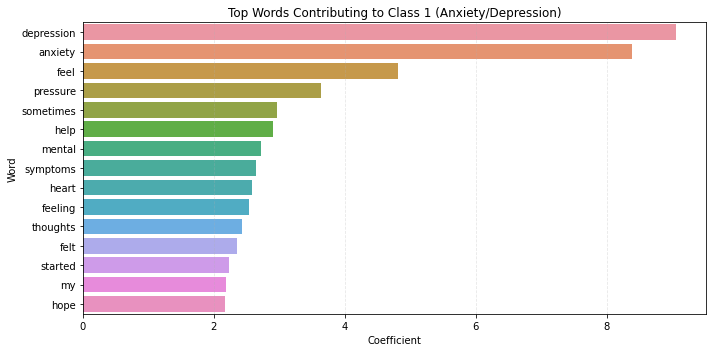

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("magma")

# Plot top 15 positive coefficients (class 1)
top_pos = df_words_sorted.head(15)
plt.figure(figsize=(10, 5))
sns.barplot(x="coef", y="word", data=top_pos)
plt.title("Top Words Contributing to Class 1 (Anxiety/Depression)")
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


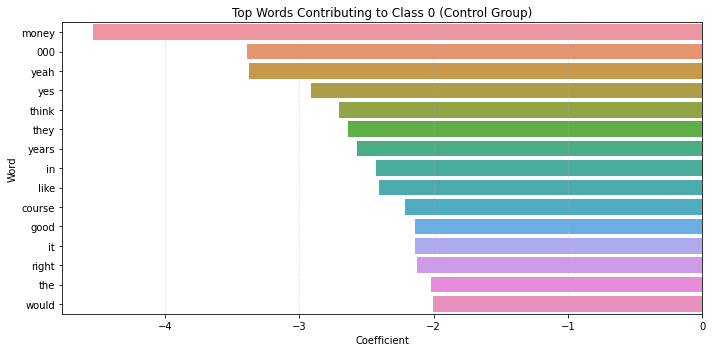

In [19]:
# Plot top 15 negative coefficients (class 0)
top_neg = df_words_sorted.tail(15).sort_values("coef")
plt.figure(figsize=(10, 5))
sns.barplot(x="coef", y="word", data=top_neg)
plt.title("Top Words Contributing to Class 0 (Control Group)")
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [20]:
# Select the top 25 most influential words by absolute coefficient value
top_25_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(25)["word"].tolist()


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Rebuild the TF-IDF matrix restricted to those 25 words
tfidf_top = TfidfVectorizer(vocabulary=top_25_words)
X_text_top = tfidf_top.fit_transform(X_text["translation"].fillna("")).toarray()


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split data using only the selected word features
X_train, X_test, y_train, y_test = train_test_split(
    X_text_top, y, test_size=0.25, random_state=42
)

# Train logistic regression on reduced word set
model_top = LogisticRegression(max_iter=1000)
model_top.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict and evaluate the model
y_pred = model_top.predict(X_test)
y_prob = model_top.predict_proba(X_test)[:, 1]

print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("🧠 AUC Score:", roc_auc_score(y_test, y_prob))


📊 Confusion Matrix:
 [[ 462  137]
 [ 129 1004]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.78       599
           1       0.88      0.89      0.88      1133

    accuracy                           0.85      1732
   macro avg       0.83      0.83      0.83      1732
weighted avg       0.85      0.85      0.85      1732

🧠 AUC Score: 0.9243325518995323


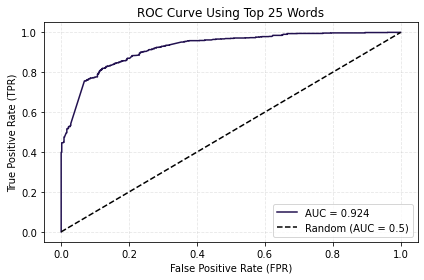

In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("magma")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Using Top 25 Words")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


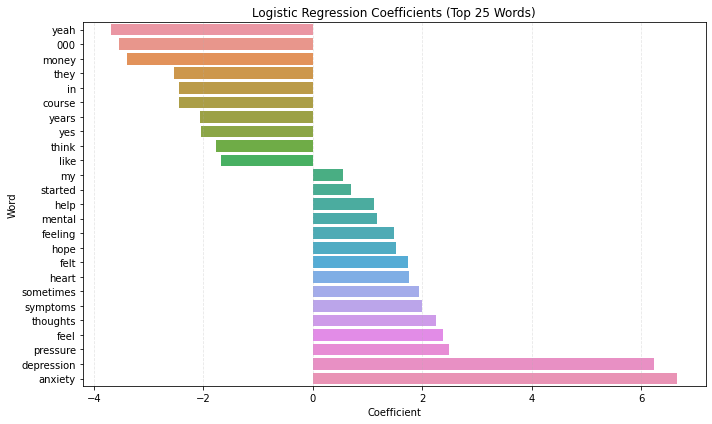

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get the coefficients from the trained model using top 25 words
coefs_top = model_top.coef_[0]
df_top_words = pd.DataFrame({
    "word": top_25_words,
    "coef": coefs_top
}).sort_values("coef")

# Plot with magma palette
sns.set_palette("magma")

plt.figure(figsize=(10, 6))
sns.barplot(x="coef", y="word", data=df_top_words)
plt.title("Logistic Regression Coefficients (Top 25 Words)")
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


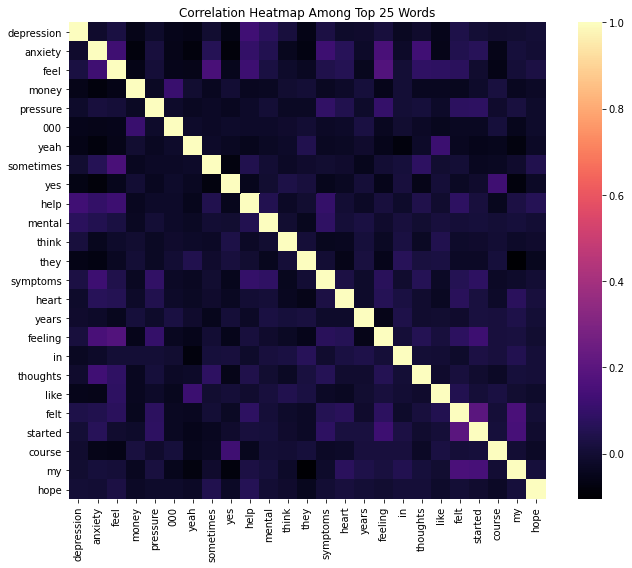

In [26]:
import numpy as np

# Create a correlation matrix from the TF-IDF vectors of top 25 words
corr_matrix = np.corrcoef(X_text_top.T)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    xticklabels=top_25_words,
    yticklabels=top_25_words,
    cmap="magma",
    square=True,
    cbar=True
)
plt.title("Correlation Heatmap Among Top 25 Words")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


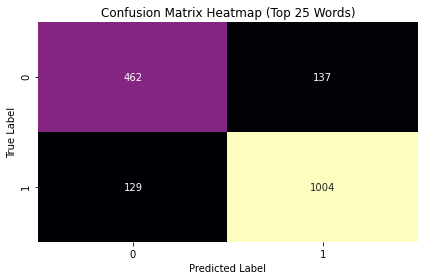

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using heatmap with magma palette
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=False)
plt.title("Confusion Matrix Heatmap (Top 25 Words)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


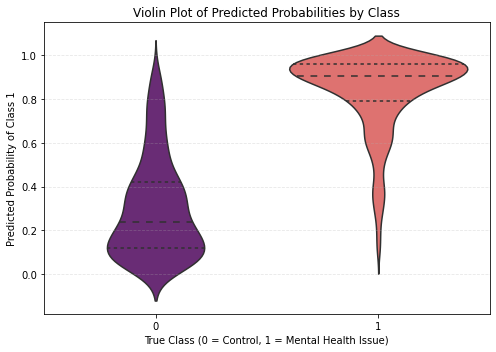

In [64]:
import pandas as pd

# Create DataFrame with predicted probabilities and true labels
df_violin = pd.DataFrame({
    "Predicted Probability": y_prob,
    "True Class": y_test.reset_index(drop=True)
})

# Plot violin plot using magma palette
plt.figure(figsize=(7, 5))
sns.violinplot(x="True Class", y="Predicted Probability", data=df_violin, palette="magma", inner="quartile")
plt.title("Violin Plot of Predicted Probabilities by Class")
plt.xlabel("True Class (0 = Control, 1 = Mental Health Issue)")
plt.ylabel("Predicted Probability of Class 1")
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Select the 50 most impactful words based on absolute coefficients
top_50_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(50)["word"].tolist()

# Re-vectorize using only those 50 words
tfidf_top = TfidfVectorizer(vocabulary=top_50_words)
X_text_top = tfidf_top.fit_transform(X_text["translation"].fillna("")).toarray()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_text_top, y, test_size=0.25, random_state=42)


In [31]:
# Train a new logistic regression model
model_top = LogisticRegression(max_iter=1000)
model_top.fit(X_train, y_train)

# Predict classes and probabilities
y_pred = model_top.predict(X_test)
y_prob = model_top.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("🧠 AUC Score:", roc_auc_score(y_test, y_prob))


📊 Confusion Matrix:
 [[ 506   93]
 [ 118 1015]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83       599
           1       0.92      0.90      0.91      1133

    accuracy                           0.88      1732
   macro avg       0.86      0.87      0.87      1732
weighted avg       0.88      0.88      0.88      1732

🧠 AUC Score: 0.9407301371659444


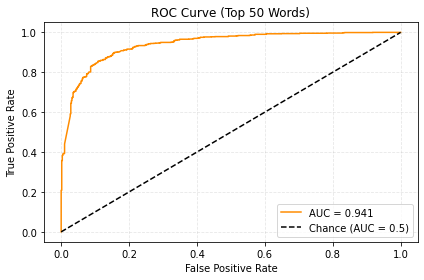

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ROC curve data
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Top 50 Words)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


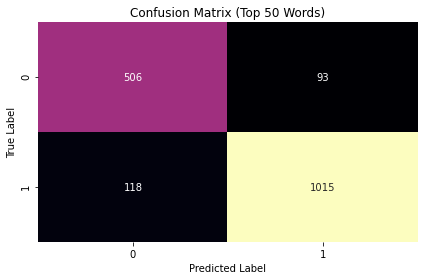

In [33]:
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot with magma palette
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=False)
plt.title("Confusion Matrix (Top 50 Words)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


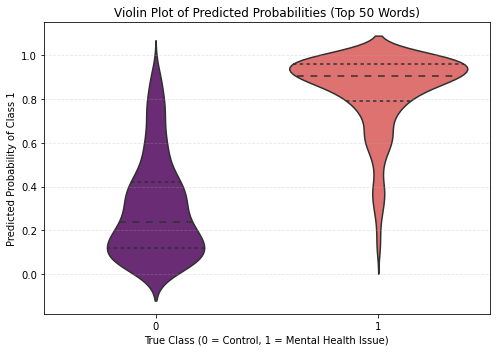

In [65]:
import pandas as pd

# DataFrame for violin plot
df_violin = pd.DataFrame({
    "Predicted Probability": y_prob,
    "True Class": y_test.reset_index(drop=True)
})

# Violin plot
plt.figure(figsize=(7, 5))
sns.violinplot(x="True Class", y="Predicted Probability", data=df_violin, palette="magma", inner="quartile")
plt.title("Violin Plot of Predicted Probabilities (Top 50 Words)")
plt.xlabel("True Class (0 = Control, 1 = Mental Health Issue)")
plt.ylabel("Predicted Probability of Class 1")
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


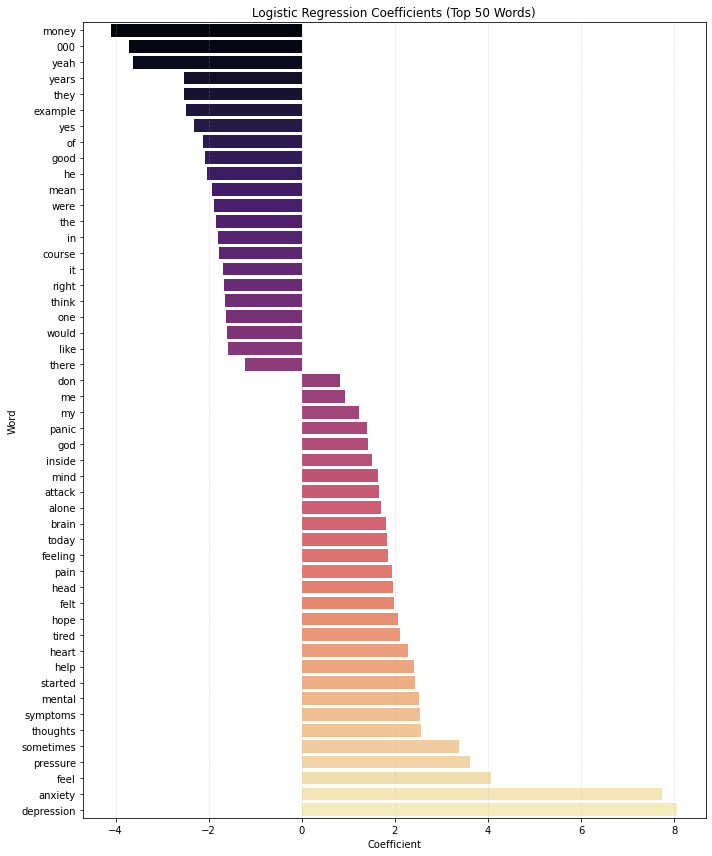

In [35]:
# Extract model coefficients
coefs_top = model_top.coef_[0]
df_top_words = pd.DataFrame({
    "word": top_50_words,
    "coef": coefs_top
}).sort_values("coef")

# Horizontal barplot
plt.figure(figsize=(10, 12))
sns.barplot(x="coef", y="word", data=df_top_words, palette="magma")
plt.title("Logistic Regression Coefficients (Top 50 Words)")
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


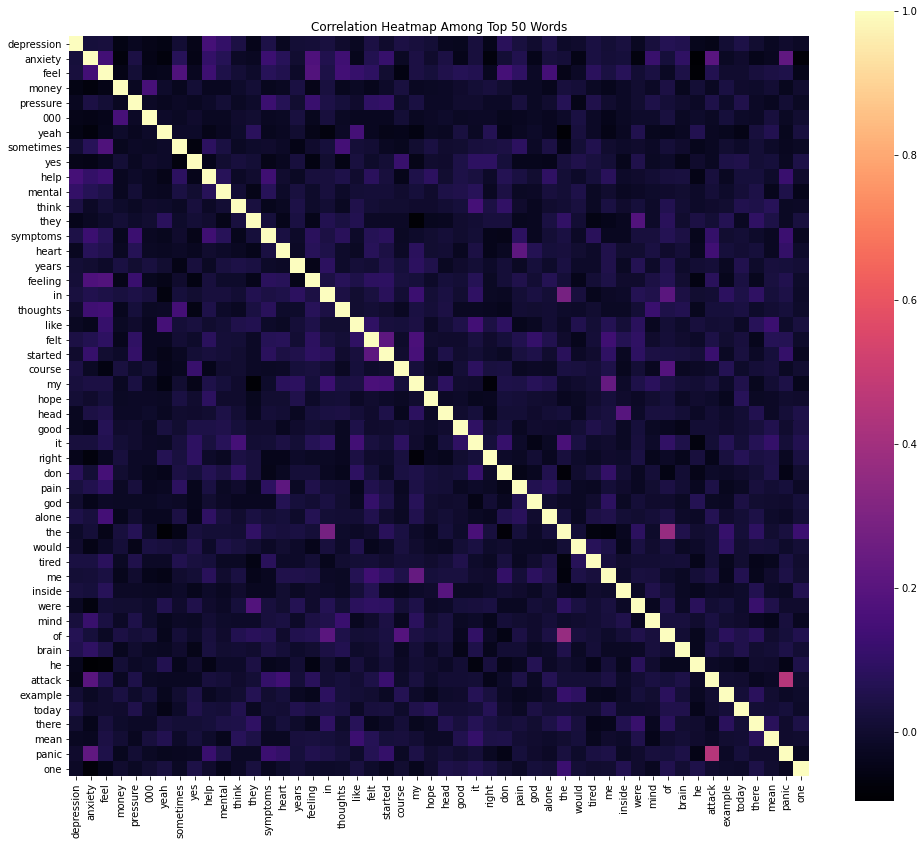

In [36]:
import numpy as np

# Compute correlation matrix
corr_matrix = np.corrcoef(X_text_top.T)

# Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    xticklabels=top_50_words,
    yticklabels=top_50_words,
    cmap="magma",
    square=True,
    cbar=True
)
plt.title("Correlation Heatmap Among Top 50 Words")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [37]:
import statsmodels.api as sm
import pandas as pd

# Create DataFrame with the names of the top 50 words
X_df_50 = pd.DataFrame(X_text_top, columns=tfidf_top.get_feature_names_out(), index=y.index)

# Add constant term for intercept
X_df_50 = sm.add_constant(X_df_50)

# Fit the Logit model using statsmodels
logit_model_50 = sm.Logit(y, X_df_50).fit()

# Display regression summary
print(logit_model_50.summary())


Optimization terminated successfully.
         Current function value: 0.261268
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 6926
Model:                          Logit   Df Residuals:                     6875
Method:                           MLE   Df Model:                           50
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                  0.5970
Time:                        10:33:26   Log-Likelihood:                -1809.5
converged:                       True   LL-Null:                       -4489.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9296      0.135     21.688      0.000       2.665       3.194
depression    18.1476      1

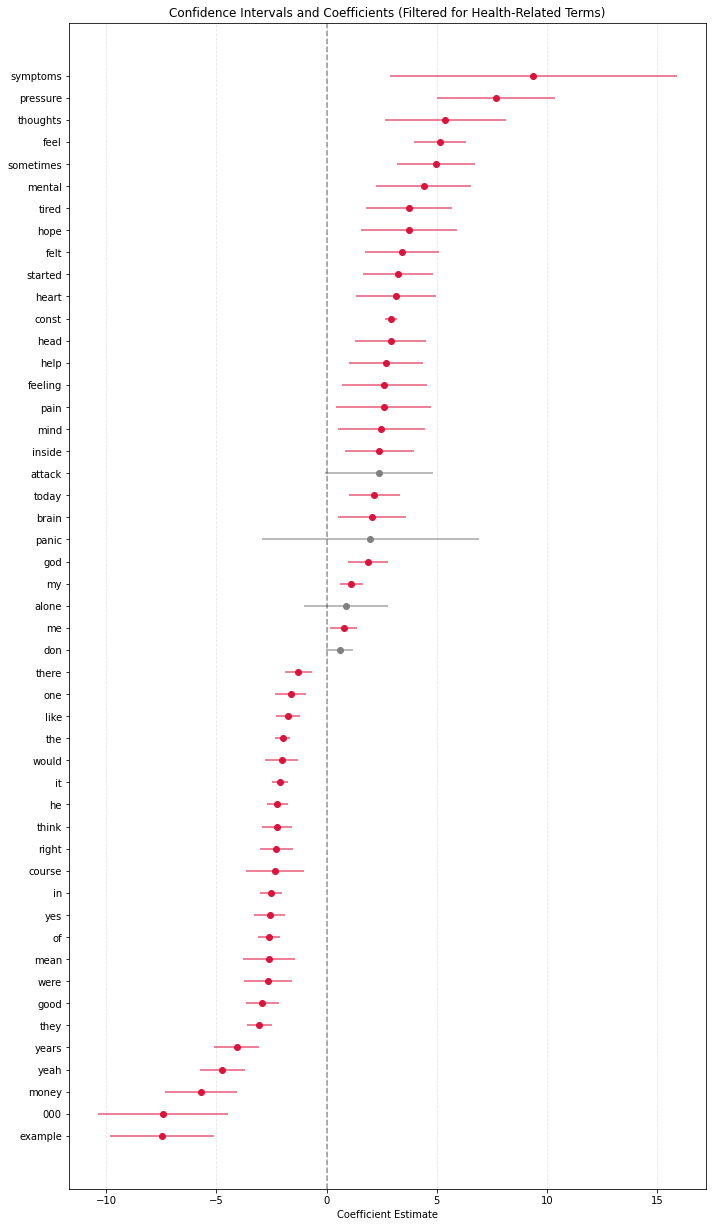

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract model results
coefs = logit_model_50.params
conf = logit_model_50.conf_int()
conf.columns = ["lower", "upper"]
pvals = logit_model_50.pvalues

# Build DataFrame
df_plot = pd.DataFrame({
    "coef": coefs,
    "lower": conf["lower"],
    "upper": conf["upper"],
    "var": coefs.index,
    "pval": pvals
}).sort_values("coef", ascending=True)

# Optional: exclude key health-related terms only if needed
excluded_vars = ["depression", "anxiety"]  # Or leave empty list [] to keep them
df_plot = df_plot[~df_plot["var"].isin(excluded_vars)]

# Assign colors based on p-value threshold
df_plot["color"] = df_plot["pval"].apply(lambda p: "crimson" if p < 0.05 else "gray")

# Plot horizontal coefficient intervals
plt.figure(figsize=(10, len(df_plot) * 0.35))
for _, row in df_plot.iterrows():
    plt.hlines(y=row["var"], xmin=row["lower"], xmax=row["upper"], color=row["color"], alpha=0.7)
    plt.plot(row["coef"], row["var"], "o", color=row["color"])
plt.axvline(x=0, linestyle="--", color="black", alpha=0.4)
plt.xlabel("Coefficient Estimate")
plt.title("Confidence Intervals and Coefficients (Filtered for Health-Related Terms)")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()



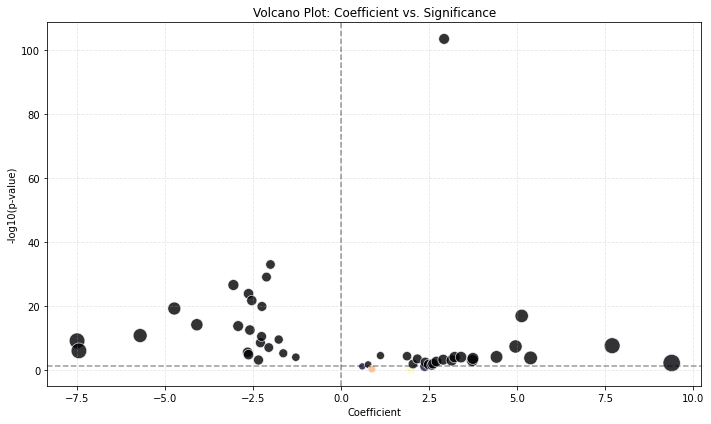

In [59]:
import numpy as np
import seaborn as sns

# Prepare data
df_plot["-log10(pval)"] = -np.log10(df_plot["pval"])
df_plot["abs_coef"] = df_plot["coef"].abs()

# Plot volcano-style chart
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x="coef",
    y="-log10(pval)",
    hue="pval",
    palette="magma",
    size="abs_coef",
    sizes=(50, 300),
    legend=False,
    alpha=0.8
)
plt.axhline(y=-np.log10(0.05), linestyle="--", color="black", alpha=0.4)
plt.axvline(x=0, linestyle="--", color="black", alpha=0.4)
plt.xlabel("Coefficient")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot: Coefficient vs. Significance")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [60]:
!pip install umap-learn



In [61]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Create DataFrame with TF-IDF values and target labels
df_text_top = pd.DataFrame(X_text_top, columns=top_50_words)
df_text_top["target"] = y.values

# Calculate mean TF-IDF per word per class
avg_tfidf_by_class = df_text_top.groupby("target").mean().T

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(avg_tfidf_by_class, cmap="magma", annot=False, linewidths=0.1)
plt.title("Average TF-IDF by Class (Top 50 Words)")
plt.xlabel("Class")
plt.ylabel("Word")
plt.tight_layout()
plt.show()



ValueError: Shape of passed values is (6926, 250), indices imply (6926, 50)

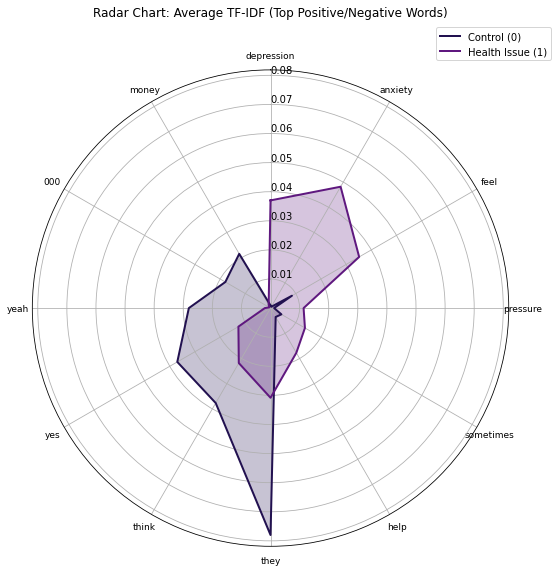

In [62]:
from math import pi

# Select top 6 positive and top 6 negative words by model coefficient
top_pos = df_words_sorted.head(6)["word"].tolist()
top_neg = df_words_sorted.tail(6)["word"].tolist()
selected_words = top_pos + top_neg

# Compute average TF-IDF values for each class (0 = Control, 1 = Health issue)
df_text_top = pd.DataFrame(X_text_top, columns=tfidf_top.get_feature_names_out())
df_text_top["target"] = y.values
radar_df = df_text_top.groupby("target")[selected_words].mean().T
radar_df.columns = ["Control (0)", "Health Issue (1)"]
radar_df["word"] = radar_df.index

# Radar chart setup
labels = radar_df["word"].tolist()
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
angles += angles[:1]

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for col in ["Control (0)", "Health Issue (1)"]:
    values = radar_df[col].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=col)
    ax.fill(angles, values, alpha=0.25)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], labels, fontsize=9)
ax.set_rlabel_position(0)
plt.title("Radar Chart: Average TF-IDF (Top Positive/Negative Words)", y=1.1)
plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()


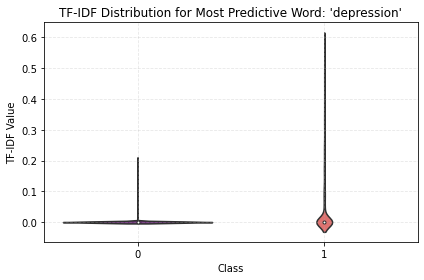

In [63]:
# Get the most predictive word (highest absolute coefficient)
strongest_word = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).iloc[0]["word"]

# Violin plot for that word
plt.figure(figsize=(6, 4))
sns.violinplot(data=df_text_top, x="target", y=strongest_word, palette="magma")
plt.title(f"TF-IDF Distribution for Most Predictive Word: '{strongest_word}'")
plt.xlabel("Class")
plt.ylabel("TF-IDF Value")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Select top 250 words with highest absolute coefficients
top_250_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(250)["word"].tolist()

# Re-vectorize using only those 250 words
tfidf_top = TfidfVectorizer(vocabulary=top_250_words)
X_text_top = tfidf_top.fit_transform(X_text["translation"].fillna("")).toarray()


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_text_top, y, test_size=0.25, random_state=42)

# Train logistic regression
model_top = LogisticRegression(max_iter=1000)
model_top.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

📊 Confusion Matrix:
 [[ 488  111]
 [  80 1053]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.84       599
           1       0.90      0.93      0.92      1133

    accuracy                           0.89      1732
   macro avg       0.88      0.87      0.88      1732
weighted avg       0.89      0.89      0.89      1732

🧠 AUC: 0.948


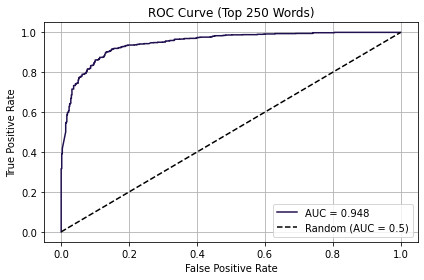

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Predict and evaluate
y_pred = model_top.predict(X_test)
y_prob = model_top.predict_proba(X_test)[:, 1]

print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print(f"🧠 AUC: {roc_auc_score(y_test, y_prob):.3f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Top 250 Words)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
import statsmodels.api as sm
import pandas as pd

# Create DataFrame with TF-IDF features and labels
X_df_250 = pd.DataFrame(X_text_top, columns=tfidf_top.get_feature_names_out(), index=y.index)

# Add constant for logit model
X_df_250 = sm.add_constant(X_df_250)

# Fit logit model
logit_model_250 = sm.Logit(y, X_df_250).fit()

# Show summary
print(logit_model_250.summary())


Optimization terminated successfully.
         Current function value: 0.196331
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 6926
Model:                          Logit   Df Residuals:                     6675
Method:                           MLE   Df Model:                          250
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                  0.6971
Time:                        10:40:32   Log-Likelihood:                -1359.8
converged:                       True   LL-Null:                       -4489.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1012      0.163     19.046      0.000       2.782       3.420
depression    35.6093      3

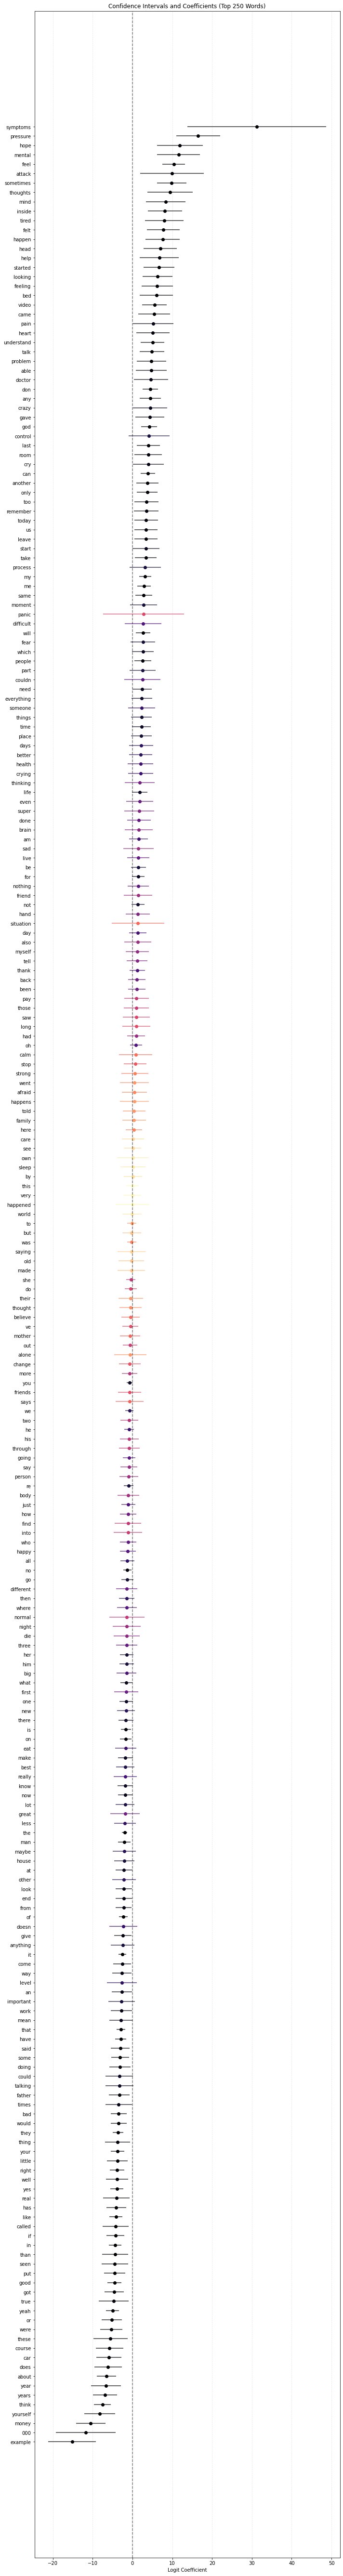

In [69]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Extract logit model data
coefs = logit_model_250.params
conf = logit_model_250.conf_int()
conf.columns = ["lower", "upper"]
pvals = logit_model_250.pvalues

# Build DataFrame for plotting
df_plot = pd.DataFrame({
    "coef": coefs,
    "lower": conf["lower"],
    "upper": conf["upper"],
    "var": coefs.index,
    "pval": pvals
}).sort_values("coef", ascending=True)

# Exclude label terms and constant
words_to_exclude = ["depression", "anxiety", "const"]
df_plot = df_plot[~df_plot["var"].isin(words_to_exclude)].reset_index(drop=True)

# Normalize p-values to get magma colors
norm = plt.Normalize(df_plot["pval"].min(), df_plot["pval"].max())
colors = plt.cm.magma(norm(df_plot["pval"].values))

# Plot confidence intervals with magma coloring
plt.figure(figsize=(10, len(df_plot) * 0.3))
for i, row in df_plot.iterrows():
    plt.hlines(y=row["var"], xmin=row["lower"], xmax=row["upper"], color=colors[i], alpha=0.8)
    plt.plot(row["coef"], row["var"], "o", color=colors[i])
plt.axvline(x=0, linestyle="--", color="black", alpha=0.5)
plt.xlabel("Logit Coefficient")
plt.title("Confidence Intervals and Coefficients (Top 250 Words)")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()



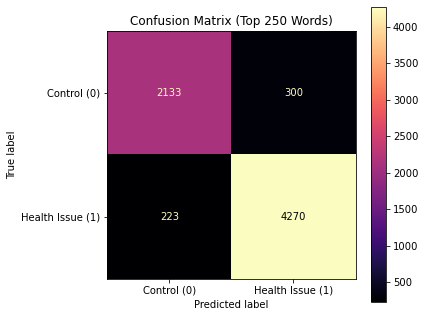

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predicted classes from the model
y_pred_250 = (logit_model_250.predict(X_df_250) > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred_250)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Control (0)", "Health Issue (1)"])

# Plot with magma-like coloring
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="magma", ax=ax, values_format='d')
plt.title("Confusion Matrix (Top 250 Words)")
plt.grid(False)
plt.tight_layout()
plt.show()


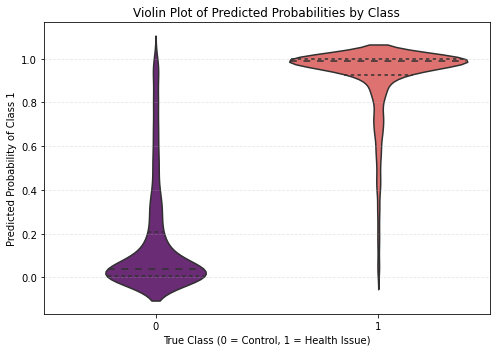

In [71]:
# Get predicted probabilities
y_prob_250 = logit_model_250.predict(X_df_250)

# Build dataframe
df_violin = pd.DataFrame({
    "Predicted Probability": y_prob_250,
    "True Class": y.reset_index(drop=True)
})

# Violin plot
plt.figure(figsize=(7, 5))
sns.violinplot(x="True Class", y="Predicted Probability", data=df_violin, palette="magma", inner="quartile")
plt.title("Violin Plot of Predicted Probabilities by Class")
plt.xlabel("True Class (0 = Control, 1 = Health Issue)")
plt.ylabel("Predicted Probability of Class 1")
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


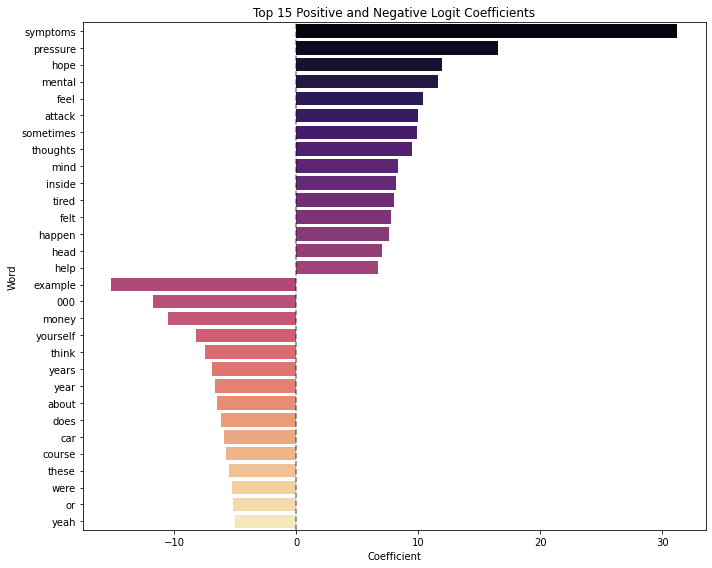

In [72]:
# Sort and select top coefficients
top_pos = df_plot.sort_values("coef", ascending=False).head(15)
top_neg = df_plot.sort_values("coef", ascending=True).head(15)
top_coef = pd.concat([top_pos, top_neg])

# Plot barplot
plt.figure(figsize=(10, 8))
sns.barplot(x="coef", y="var", data=top_coef, palette="magma")
plt.axvline(0, linestyle="--", color="black", alpha=0.5)
plt.title("Top 15 Positive and Negative Logit Coefficients")
plt.xlabel("Coefficient")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


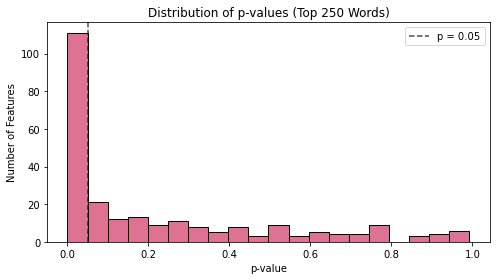

In [73]:
plt.figure(figsize=(7, 4))
sns.histplot(df_plot["pval"], bins=20, kde=False, color=sns.color_palette("magma")[3])
plt.axvline(x=0.05, linestyle="--", color="black", alpha=0.7, label="p = 0.05")
plt.title("Distribution of p-values (Top 250 Words)")
plt.xlabel("p-value")
plt.ylabel("Number of Features")
plt.legend()
plt.tight_layout()
plt.show()


# COMBINED TEXT AND OTHER METRICS

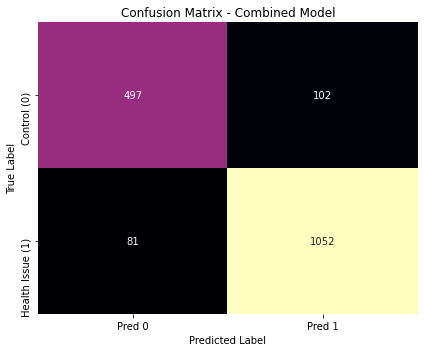


Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       599
           1       0.91      0.93      0.92      1133

    accuracy                           0.89      1732
   macro avg       0.89      0.88      0.88      1732
weighted avg       0.89      0.89      0.89      1732

AUC: 0.9550


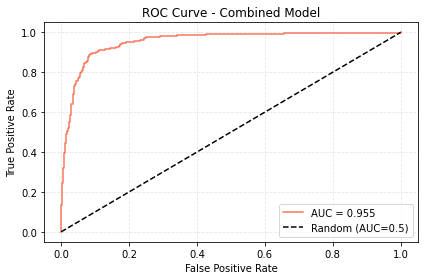

In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text using top 300 words
tfidf_300 = TfidfVectorizer(max_features=300)
X_text_full = tfidf_300.fit_transform(X_text["translation"].fillna("")).toarray()

# Combine scaled numeric features with TF-IDF features
X_combined = np.hstack([X_scaled, X_text_full])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# Train logistic regression
model_combined = LogisticRegression(max_iter=1000)
model_combined.fit(X_train, y_train)

# Predictions and probabilities
y_pred = model_combined.predict(X_test)
y_prob = model_combined.predict_proba(X_test)[:, 1]

# Confusion matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Control (0)", "Health Issue (1)"], columns=["Pred 0", "Pred 1"])
plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="magma", cbar=False)
plt.title("Confusion Matrix - Combined Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# AUC
auc_score = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc_score:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", color=sns.color_palette("magma")[4])
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.5)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Combined Model")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


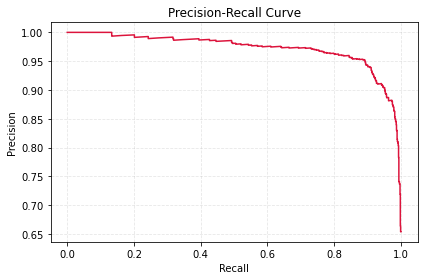

In [75]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color="crimson")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


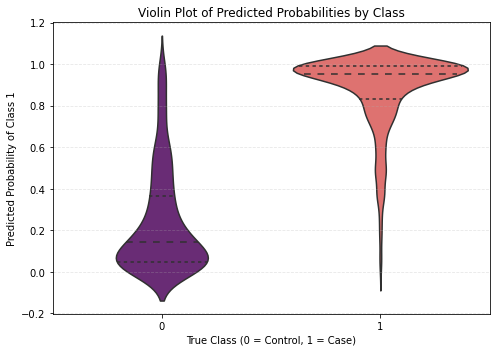

In [76]:
import pandas as pd
import seaborn as sns

# Build DataFrame for plotting
df_violin = pd.DataFrame({
    "Predicted Probability": y_prob,
    "True Class": pd.Series(y_test)
})

plt.figure(figsize=(7, 5))
sns.violinplot(
    x="True Class", 
    y="Predicted Probability", 
    data=df_violin, 
    palette="magma", 
    inner="quartile"
)
plt.title("Violin Plot of Predicted Probabilities by Class")
plt.xlabel("True Class (0 = Control, 1 = Case)")
plt.ylabel("Predicted Probability of Class 1")
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# SUBGROUPS


In [83]:
# Check all object-type columns and preview their values
object_cols = df.select_dtypes(include="object").columns.tolist()
for col in object_cols:
    print(f"\n📌 Column: {col}")
    print(df[col].dropna().astype(str).head(3).to_list())
